In [469]:
##############################
#
# Created by Jerad Hoy
# Date 5/26/2015
#
# Creates network from edge table and routes water.
#
#
#
##############################

#####################
#       TODO
# 1. Write data to text file
# 2. Integrate monthly runoff and velocity
# 4. Include width and depth from raymond to better approximate sRiv
# 2. Seperate into two r files maybe
# 3. Generate graphs of edges 
#
#
#
#####################

In [28]:
library(sp)
library(maptools)
library(raster)
library(igraph)
library(rgdal)
library(ncdf)
library(raster)
library(foreach)
library(doParallel)
options(scipen=999)
library(mailR)
notifyMe <- send.mail(from = "jeradhoy@gmail.com",
          to = "jeradhoy@gmail.com",
          subject = "Job Finished",
          body = "Body of the email",
          smtp = list(host.name = "aspmx.l.google.com", port = 25),
          authenticate = FALSE,
          send = TRUE)

In [11]:
ncFile <- open.ncdf("/Users/hoy/Desktop/MSUWC/Data/Output_Lamar_Runoff/merged.nc")
ncFile

[1] "file /Users/hoy/Desktop/MSUWC/Data/Output_Lamar_Runoff/merged.nc has 3 dimensions:"
[1] "lon   Size: 69"
[1] "lat   Size: 81"
[1] "time   Size: 12045"
[1] "------------------------"
[1] "file /Users/hoy/Desktop/MSUWC/Data/Output_Lamar_Runoff/merged.nc has 4 variables:"
[1] "double spack[lon,lat,time]  Longname:Snowpack Missval:-9000000000000000086637831186808832"
[1] "double dro[lon,lat,time]  Longname:Total runoff from all soil layers Missval:-9000000000000000086637831186808832"
[1] "double dsro[lon,lat,time]  Longname:Surface Runoff Missval:-9000000000000000086637831186808832"
[1] "double dssro[lon,lat,time]  Longname:Subsurface Runoff Missval:-9000000000000000086637831186808832"

In [31]:
generateRunoff <- function(ncFile, catchmentPolygons, runoffVar){
    brick <- brick(ncFile, varname=runoffVar)
    runoff <- data.frame(t(extract(brick, catchmentsInBounds, na.rm=TRUE, fun=sum)))
    #convert from mm/m2/month to m3/month
    runoff <- runoff/1000*1000000/(30*24*60*60)
    colnames(runoff) <- catchmentsInBounds$HydroID
    rownames(runoff) <- c(1:dim(brick)[3])
    return(runoff)
}

In [3]:
routeWater <- function(edges, Rs){#, varTable=FALSE, plotNetwork=FALSE, writeData=FALSE){
    
    #Order edges by Shreve order so calculation is in right order
    edges <- edges[order(edges$RiverOrder),]
    
    results <- list(
        qIn = matrix(0, nrow=nrow(Rs), ncol=ncol(Rs), 
                dimnames=list(c(1:nrow(Rs)), edges$HydroID_1)),
        qOut = matrix(0, nrow=nrow(Rs), ncol=ncol(Rs), 
                dimnames=list(c(1:nrow(Rs)), edges$HydroID_1))
    )
    
    for(i in 1:nrow(edges)){
        for(month in 1:nrow(Rs)){
            
            hydroID <- edges[i,]$HydroID_1
            
            if(edges[i,]$RiverOrder == 1){
                qIn <- 0
            } else {
                qIn <- sum(results$qOut[month, 
                    as.character(
                        edges[edges$NextDownID == edges[i,]$HydroID_1,]$HydroID_1)])
                results$qIn[month, as.character(hydroID)] <- qIn #sum(results$qIn[month,c(as.character(parentEdges$HydroID_1))])
            }
            
            results$qOut[month, as.character(hydroID)] <- qIn + Rs[month,as.character(hydroID)]

        }
    }
    
    return(results)
}

In [4]:
assignContribArea <- function(edges){
    edges <- edges[order(edges$RiverOrder),]
    edges$ContribArea <- NA
    
    for(i in 1:nrow(edges)){
            
            if(edges[i,]$RiverOrder == 1){
                #print(paste("Area of stream order", edges[i,]$RiverOrder, "is", edges[i,]$Shape_Ar_1))
                edges[i,"ContribArea"] <- edges[i,]$Shape_Ar_1
            } else {
                #print(paste("Area of stream order", edges[i,]$RiverOrder, "is", sum(edges[edges$NextDownID == edges[i,]$HydroID_1,]$Shape_Ar_1) + edges[i,]$Shape_Ar_1))
                #print(sum(edges[edges$NextDownID == edges[i,]$HydroID_1,]$Shape_Ar_1) + edges[i,]$Shape_Ar_1)
                edges[i,"ContribArea"] <- sum(edges[edges$NextDownID == edges[i,]$HydroID_1,]$ContribArea) + edges[i,]$Shape_Ar_1 #sum(results$qIn[month,c(as.character(parentEdges$HydroID_1))])
            }

    }
    return(edges)
}

In [32]:
#rep(month.abb, 10)
#seq(as.Date("2000/1/1"), by="day", length.out=nrow(runoff))
dates <- seq(as.Date("1980/1/1"), as.Date("2012/12/31"), by="day")
dates[dates != ]
length(dates)       
       #, length.out=33*365)

 [1] "1980-01-01" "1980-01-02" "1980-01-03" "1980-01-04" "1980-01-05"
 [6] "1980-01-06" "1980-01-07" "1980-01-08" "1980-01-09" "1980-01-10"

[1] 12054

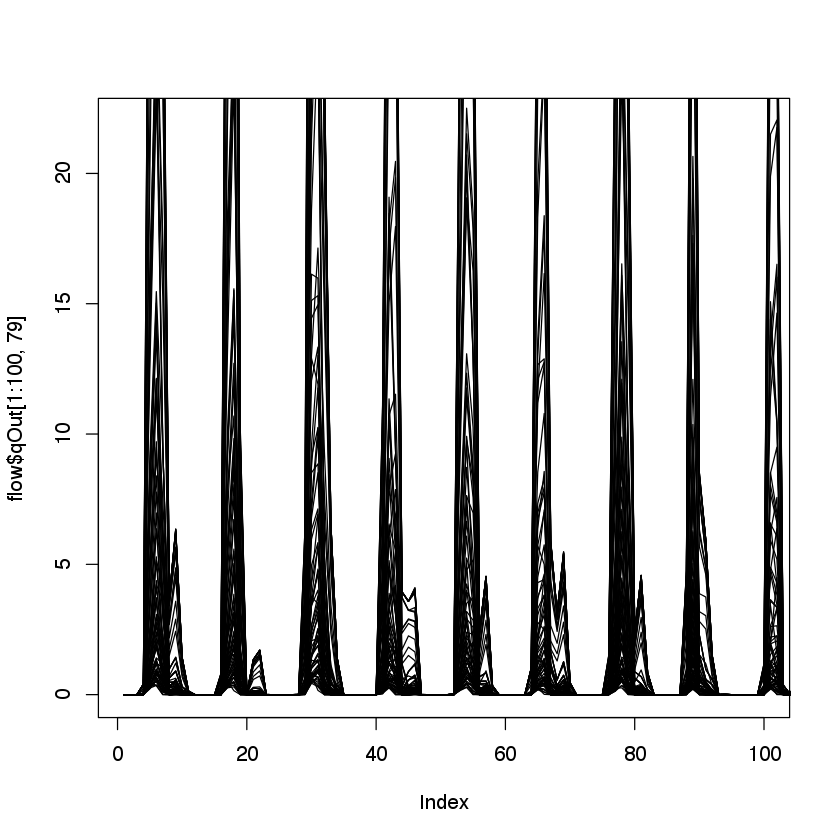

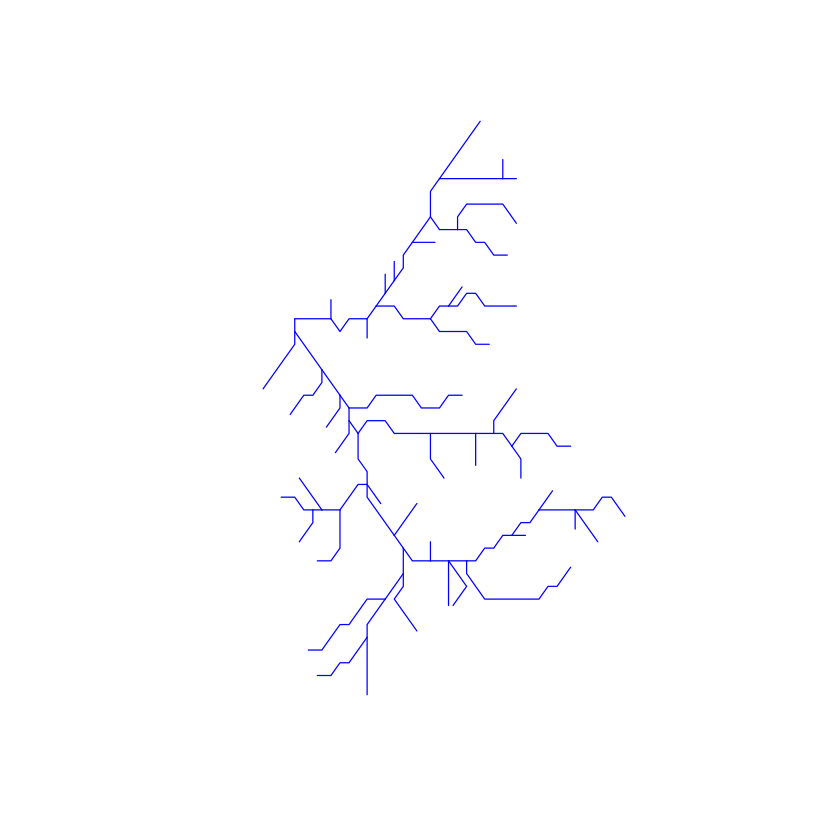

In [470]:
plot(flow$qOut[1:100,79], type="l", ylim=c(0, 22))
for(edge in 2:ncol(flow$qOut)){
    lines(flow$qOut[,edge])
}
plot(edgesInBounds, col="blue", )

## Edge Processing and Routing Without igraph

OGR data source with driver: ESRI Shapefile 
Source: "/Users/hoy/Desktop/MSUWC/Data/Catchments", layer: "Catchments"
with 71772 features
It has 11 fields


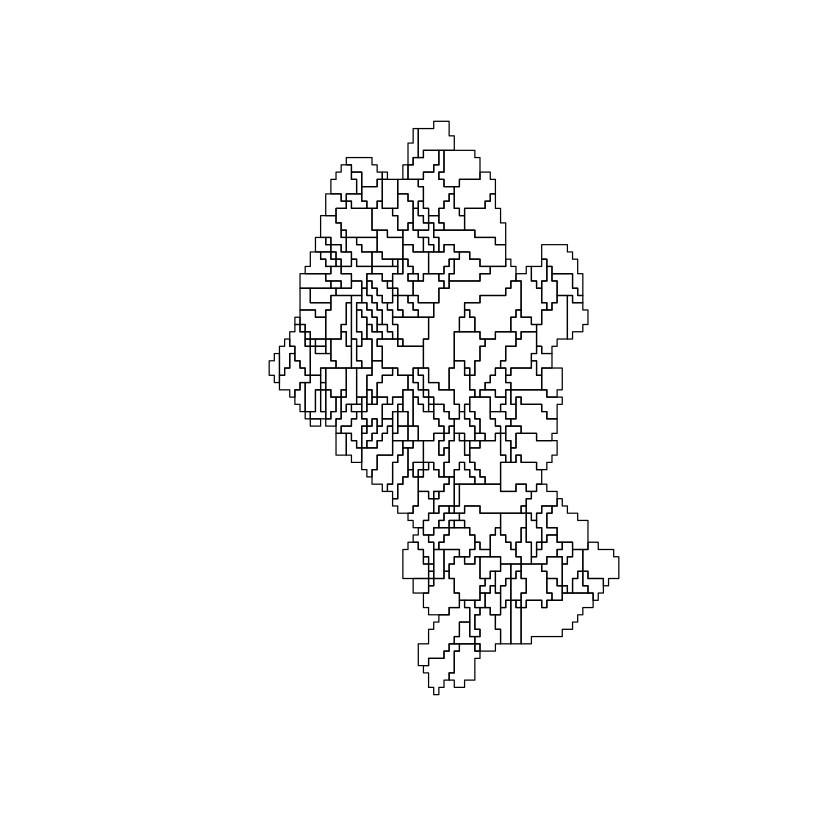

In [29]:
catchments <- readOGR("/Users/hoy/Desktop/MSUWC/Data/Catchments", "Catchments", stringsAsFactors=FALSE)
#catchInBounds <- catchments[catchments$HydroID %in% as.numeric(names(runoff)),]
catchmentCodes <- catchments$HUC10
catchmentCodes[is.na(catchmentCodes)] <- 0
catchments$HUC10 <- catchmentCodes
catchmentsInBounds <- catchments[catchments$HUC10 %in% c(1007000105, 1007000106),]
plot(catchmentsInBounds)

In [32]:
notifyMe

[1] "Java-Object{org.apache.commons.mail.SimpleEmail@513bd574}"

In [33]:
runoff <- generateRunoff("/Users/hoy/Desktop/MSUWC/Data/Output_Lamar_Runoff/merged.nc", catchmentsInBounds, "dsro")
notifyMe

[1] "Java-Object{org.apache.commons.mail.SimpleEmail@513bd574}"

In [34]:
hydroEdges <- readOGR("/Users/hoy/Desktop/MSUWC/Data/hydroEdge", "hydroEdge")

OGR data source with driver: ESRI Shapefile 
Source: "/Users/hoy/Desktop/MSUWC/Data/hydroEdge", layer: "hydroEdge"
with 71743 features
It has 20 fields


Warning message:
In readOGR("/Users/hoy/Desktop/MSUWC/Data/hydroEdge", "hydroEdge"): Z-dimension discarded

In [35]:
edgesInBounds <- hydroEdges[hydroEdges$DrainID %in% as.numeric(names(runoff)),]
length(edgesInBounds)
#edgesInBounds <- assignContribArea(edgesInBounds)

[1] 209

In [36]:
flow <- routeWater(edgesInBounds, runoff)

In [ ]:
flow

In [23]:
runoff <- generateRunoff("/Users/hoy/Desktop/MSUWC/Data/UL_stand_monthly_p100_ID80408.nc", readOGR("/Users/hoy/Desktop/MSUWC/Data/Catchments", "Catchments", stringsAsFactors=FALSE), "msro", 1007000105)

OGR data source with driver: ESRI Shapefile 
Source: "/Users/hoy/Desktop/MSUWC/Data/Catchments", layer: "Catchments"
with 71772 features
It has 11 fields


In [24]:
hydroEdges <- readOGR("/Users/hoy/Desktop/MSUWC/Data/hydroEdge", "hydroEdge")

OGR data source with driver: ESRI Shapefile 
Source: "/Users/hoy/Desktop/MSUWC/Data/hydroEdge", layer: "hydroEdge"
with 71743 features
It has 20 fields


Warning message:
In readOGR("/Users/hoy/Desktop/MSUWC/Data/hydroEdge", "hydroEdge"): Z-dimension discarded

In [467]:
edgesInBounds <- hydroEdges[hydroEdges$DrainID %in% as.numeric(names(runoff)),]
length(edgesInBounds)
edgesInBounds <- assignContribArea(edgesInBounds)

[1] 79

In [25]:
catchments <- readOGR("/Users/hoy/Desktop/MSUWC/Data/Catchments", "Catchments", stringsAsFactors=FALSE)
#catchInBounds <- catchments[catchments$HydroID %in% as.numeric(names(runoff)),]

OGR data source with driver: ESRI Shapefile 
Source: "/Users/hoy/Desktop/MSUWC/Data/Catchments", layer: "Catchments"
with 71772 features
It has 11 fields


In [461]:
i = 76
edgesInBounds$ContribArea <- 0
sum(edgesInBounds[edgesInBounds$NextDownID == edgesInBounds[i, ]$HydroID_1,]$ContribArea)

[1] 0

In [444]:
edgesInBounds$ContribArea <- 0
typeof(edgesInBounds[1,]$ContribArea)
typeof(edgesInBounds[1,]$Shape_Ar_1)
#edgesInBounds[1:5,]
edgesInBounds[1,"ContribArea"] <- 5
edgesInBounds[1:5,]

[1] "double"

[1] "double"

                                       geometry OID_ Shape_Leng HydroID DrainID
60893 MULTILINESTRING((-109.9833 44.95833 ...))    0 0.05303301  371398   60749
60894 MULTILINESTRING((-109.9625 44.92083 ...))    0 0.05833333  371400   61027
60895 MULTILINESTRING((-109.9625 44.93333 ...))    0 0.01250000  371402   60962
60896   MULTILINESTRING((-109.95 44.92083 ...))    0 0.01250000  371404   61028
61144 MULTILINESTRING((-110.0208 44.92083 ...))    0 0.02845178  371897   61026
                  FType FlowDir EdgeType Enabled FROM_NODE TO_NODE OBJECTID
60893 Synthetic Channel       1        1       1     61001   61002    60749
60894 Synthetic Channel       1        1       1     61003   61002    61027
60895 Synthetic Channel       1        1       1     61004   61003    60962
60896 Synthetic Channel       1        1       1     61005   61003    61028
61144 Synthetic Channel       1        1       1     61002   61250    61026
      Shape_Le_1   Shape_Area HydroID_1 GridID NextDownID RiverO

In [394]:
edgesInBounds[1,] <- 10

Warning message:
In `[<-.factor`(`*tmp*`, iseq, value = 10): invalid factor level, NA generated

In [395]:
edgesInBounds[1:5,]

                                       geometry OID_  Shape_Leng HydroID
60893 MULTILINESTRING((-109.9833 44.95833 ...))   10 10.00000000      10
60894 MULTILINESTRING((-109.9625 44.92083 ...))    0  0.05833333  371400
60895 MULTILINESTRING((-109.9625 44.93333 ...))    0  0.01250000  371402
60896   MULTILINESTRING((-109.95 44.92083 ...))    0  0.01250000  371404
61144 MULTILINESTRING((-110.0208 44.92083 ...))    0  0.02845178  371897
      DrainID             FType FlowDir EdgeType Enabled FROM_NODE TO_NODE
60893      10              <NA>      10       10      10        10      10
60894   61027 Synthetic Channel       1        1       1     61003   61002
60895   60962 Synthetic Channel       1        1       1     61004   61003
60896   61028 Synthetic Channel       1        1       1     61005   61003
61144   61026 Synthetic Channel       1        1       1     61002   61250
      OBJECTID Shape_Le_1    Shape_Area HydroID_1 GridID NextDownID RiverOrder
60893       10 10.0000000 10.0000

In [346]:
flow <- routeWater(edgesInBounds, runoff)

In [348]:
flow

$qIn
    60749 60962 61028 61202 61470 61383 61612 61684 61758 61759 61830 61968
1       0     0     0     0     0     0     0     0     0     0     0     0
2       0     0     0     0     0     0     0     0     0     0     0     0
3       0     0     0     0     0     0     0     0     0     0     0     0
4       0     0     0     0     0     0     0     0     0     0     0     0
5       0     0     0     0     0     0     0     0     0     0     0     0
6       0     0     0     0     0     0     0     0     0     0     0     0
7       0     0     0     0     0     0     0     0     0     0     0     0
8       0     0     0     0     0     0     0     0     0     0     0     0
9       0     0     0     0     0     0     0     0     0     0     0     0
10      0     0     0     0     0     0     0     0     0     0     0     0
11      0     0     0     0     0     0     0     0     0     0     0     0
12      0     0     0     0     0     0     0     0     0     0     0     0
13      0     0     0     0     0     0     0     0     0     0     0     0
14      0     0     0     0     0     0     0     0     0     0     0     0
15      0     0     0     0     0     0     0     0     0     0     0     0
16      0     0     0     0     0     0     0     0     0     0     0     0
17      0     0     0     0     0     0     0     0     0     0     0     0
18      0     0     0     0     0     0     0     0     0     0     0     0
19      0     0     0     0     0     0     0     0     0     0     0     0
20      0     0     0     0     0     0     0     0     0     0     0     0
21      0     0     0     0     0     0     0     0     0     0     0     0
22      0     0     0     0     0     0     0     0     0     0     0     0
23      0     0     0     0     0     0     0     0     0     0     0     0
24      0     0     0     0     0     0     0     0     0     0     0     0
25      0     0     0     0     0     0     0     0     0     0     0     0
26      0     0     0     0     0     0     0     0     0     0     0     0
27      0     0     0     0     0     0     0     0     0     0     0     0
28      0     0     0     0     0     0     0     0     0     0     0     0
29      0     0     0     0     0     0     0     0     0     0     0     0
30      0     0     0     0     0     0     0     0     0     0     0     0
31      0     0     0     0     0     0     0     0     0     0     0     0
32      0     0     0     0     0     0     0     0     0     0     0     0
33      0     0     0     0     0     0     0     0     0     0     0     0
34      0     0     0     0     0     0     0     0     0     0     0     0
35      0     0     0     0     0     0     0     0     0     0     0     0
36      0     0     0     0     0     0     0     0     0     0     0     0
37      0     0     0     0     0     0     0     0     0     0     0     0
38      0     0     0     0     0     0     0     0     0     0     0     0
39      0     0     0     0     0     0     0     0     0     0     0     0
40      0     0     0     0     0     0     0     0     0     0     0     0
41      0     0     0     0     0     0     0     0     0     0     0     0
42      0     0     0     0     0     0     0     0     0     0     0     0
43      0     0     0     0     0     0     0     0     0     0     0     0
44      0     0     0     0     0     0     0     0     0     0     0     0
45      0     0     0     0     0     0     0     0     0     0     0     0
46      0     0     0     0     0     0     0     0     0     0     0     0
47      0     0     0     0     0     0     0     0     0     0     0     0
48      0     0     0     0     0     0     0     0     0     0     0     0
49      0     0     0     0     0     0     0     0     0     0     0     0
50      0     0     0     0     0     0     0     0     0     0     0     0
51      0     0     0     0     0     0     0     0     0     0     0     0
52      0     0     0     0     0     0    

ERROR: Error in as.double(y): cannot coerce type 'S4' to vector of type 'double'


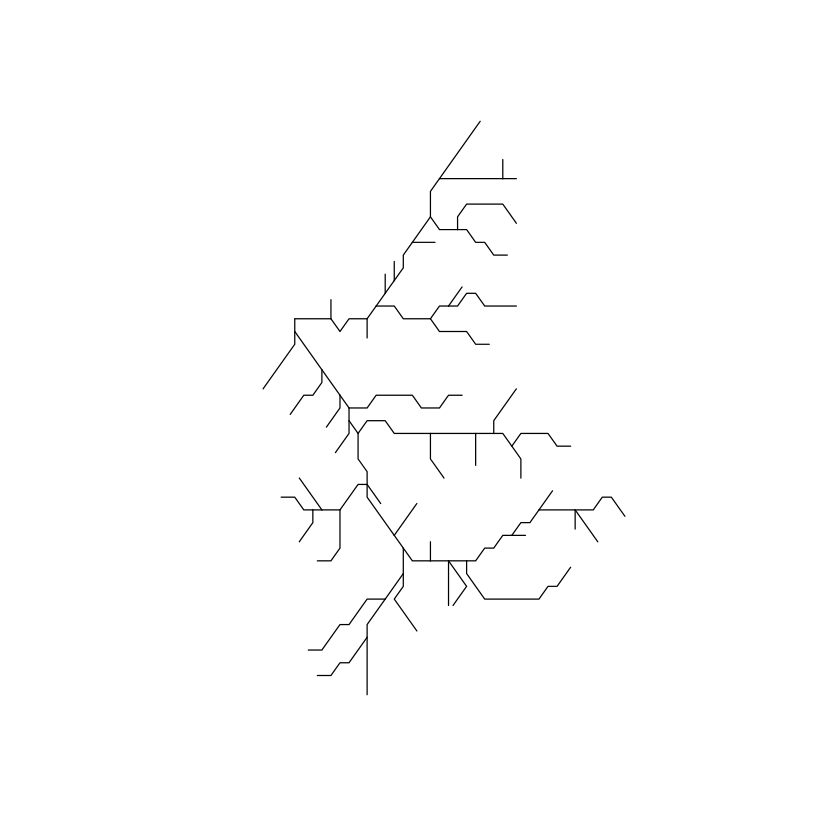

ERROR: Error in curve(expr = x, from = from, to = to, xlim = xlim, ylab = ylab, : 'expr' did not evaluate to an object of length 'n'


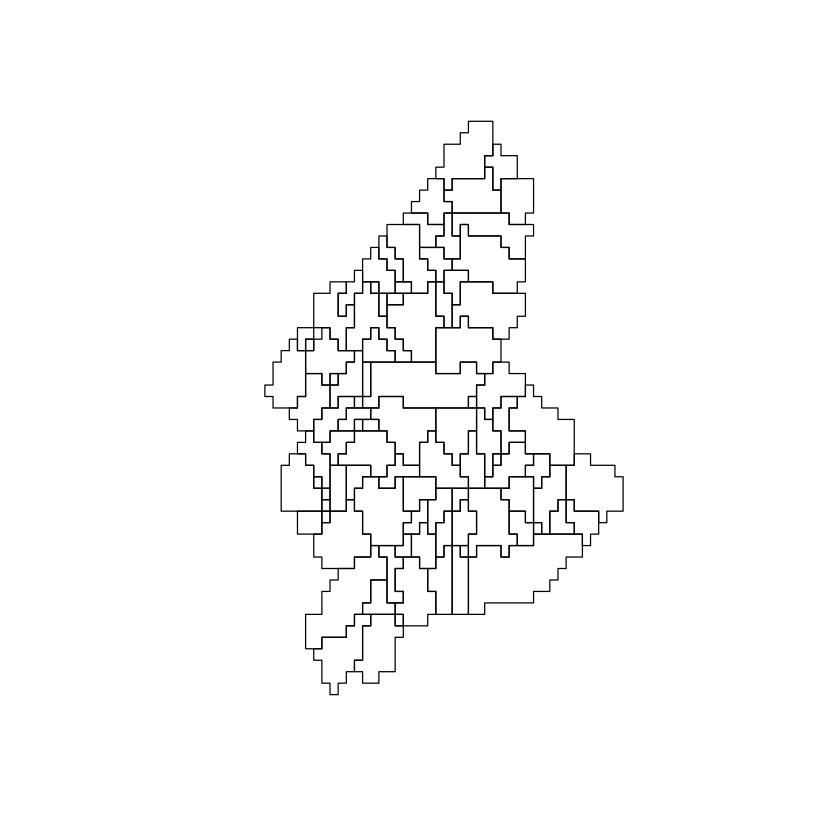

In [141]:
plot(edgesInBounds)
lines(catchInBounds)
plot(catchInBounds)
plot(edges)

# Actual Edge Processing

In [135]:
catchments <- readOGR("/Users/hoy/Desktop/MSUWC/Data/Catchments", "Catchments", stringsAsFactors=FALSE)

OGR data source with driver: ESRI Shapefile 
Source: "/Users/hoy/Desktop/MSUWC/Data/Catchments", layer: "Catchments"
with 71772 features
It has 11 fields


In [136]:
catchmentCodes <- catchments$HUC10
catchmentCodes[is.na(catchmentCodes)] <- 0
catchments$HUC10 <- catchmentCodes

In [137]:
catchInBounds <- catchments[catchments$HUC10 == 1007000105,]

## Note: Shape_Leng is in Degrees

In [55]:
bhEdgesShp <- readOGR("/Users/hoy/Desktop/bhEdges", "bhEdges")
#print(bhEdgesShp[1:5,])

OGR data source with driver: ESRI Shapefile 
Source: "/Users/hoy/Desktop/bhEdges", layer: "bhEdges"
with 1307 features
It has 9 fields


Warning message:
In readOGR("/Users/hoy/Desktop/bhEdges", "bhEdges"): Z-dimension discarded

ERROR: Error in vapply(seq_along(mapped), function(i) {: values must be length 1,
 but FUN(X[[4]]) result is length 0


In [102]:
a <- coordinates(bhEdgesShp[1,])
#print(a)
print(a)[[1]]

ERROR: Error in coordinates(bhEdgesShp[1, ]): error in evaluating the argument 'obj' in selecting a method for function 'coordinates': Error: object 'bhEdgesShp' not found



ERROR: Error in print(a): error in evaluating the argument 'x' in selecting a method for function 'print': Error: object 'a' not found



In [31]:
bhEdgesShp$x.coords

NULL

In [35]:
bhEdges <- data.frame(fromNode = bhEdgesShp$HydroEdg_4, 
                    toNode = bhEdgesShp$HydroEdg_3,
                    order = bhEdgesShp$Catchmen_1,
                    length = bhEdgesShp$HydroEdge_,
                    catchID = bhEdgesShp$HydroEdg_1)

ERROR: Error in eval(expr, envir, enclos): object 'bhEdgeshh' not found


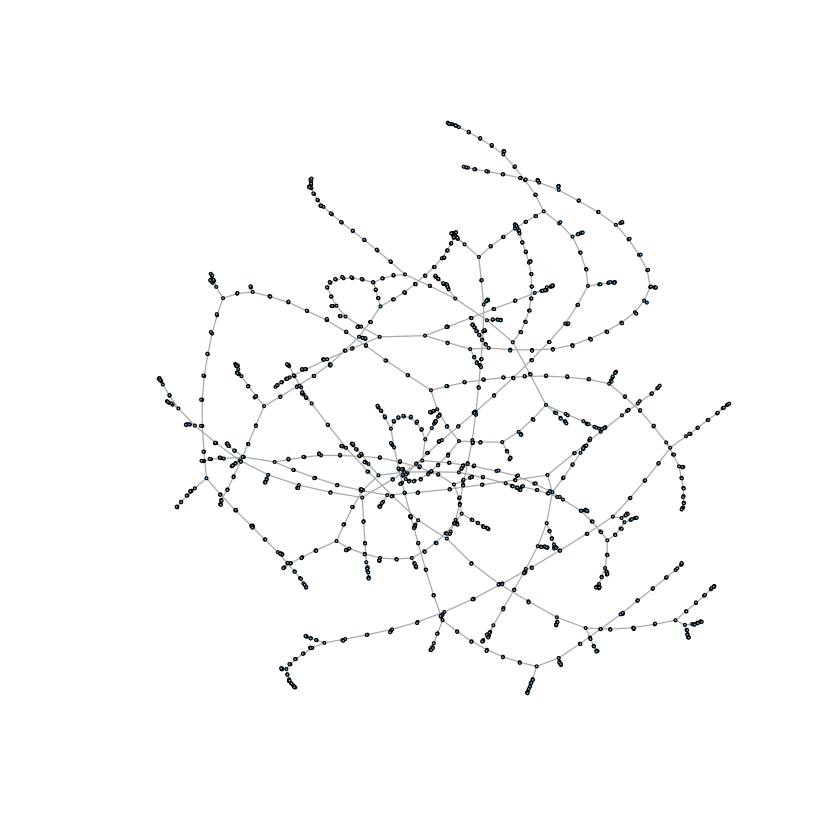

In [47]:
df <- bhEdgeshh
net <- createNetwork(df)
V(net)$size = 1
plot(net, vertex.label=NA, edge.label=NA, edge.arrow.mode=0)

[1] 20382

In [ ]:
df <- hydroEdges
net <- createNetwork(df)

runoff <- createRandomRunoff(nrow(df), 1)
runoff
#list.edge.attributes(net)
#print(data.frame(catchID=E(net)$catchID, qIn=E(net)$qIn, qOut=E(net)$qOut, sRiv=E(net)$sRiv))


#print(data.frame(name=V(net)$name))
V(net)$size = 5
routeWater(net, runoff, varTable=TRUE, plotNetwork=TRUE)
#runRiverRouting(createNetwork(df), createRandomRunoff(nrow(df), 1))

ERROR: Error in sprintf(wrap, header, body): 'fmt' length exceeds maximal format length 8192


In [448]:
hydroEdges <- data.frame(fromNode = hydroEdgeShp$FROM_NODE, 
                    toNode = hydroEdgeShp$TO_NODE,
                    order = hydroEdgeShp$RiverOrder,
                    length = hydroEdgeShp$Shape_Leng *  ,
                    catchID = hydroEdgeShp$DrainID)
hydroEdges[1:10,]

fromNode toNode order     length catchID
1         1      2     1 0.08809223       2
2         3      2     1 0.06767767       3
3         4      5     1 0.24903980       1
4         2      6     2 0.04023689       4
5         6      5     3 0.05345178       6
6         7      6     1 0.05446278       7
7         5      8     4 0.08047379       5
8         9      8     1 0.02601100       8
9        10     11     1 0.06107023      11
10        8     11     5 0.03678511       9

[,1] [,2] [,3] [,4] [,5] [,6] [,7] [,8] [,9] [,10]
[1,]   18   27   24   24   26   25   13   29   11    27

   catchID order      qIn     qOut     sRiv
1        2     1   0.0000  16.2000  18.0000
2        3     1   0.0000  24.3000  27.0000
3        1     1   0.0000  21.6000  24.0000
4        7     1   0.0000  21.6000  24.0000
5        8     1   0.0000  23.4000  26.0000
6       11     1   0.0000  22.5000  25.0000
7        4     2  40.5000  48.1500  53.5000
8        6     3  69.7500  88.8750  98.7500
9        5     4 110.4750 109.3275 121.4750
10       9     5 132.7275 143.7548 159.7275


IGRAPH DN-- 11 10 -- 
+ attr: name (v/c), size (v/n), order (e/n), length (e/n), catchID
  (e/n), qIn (e/n), qOut (e/n), sRiv (e/n)

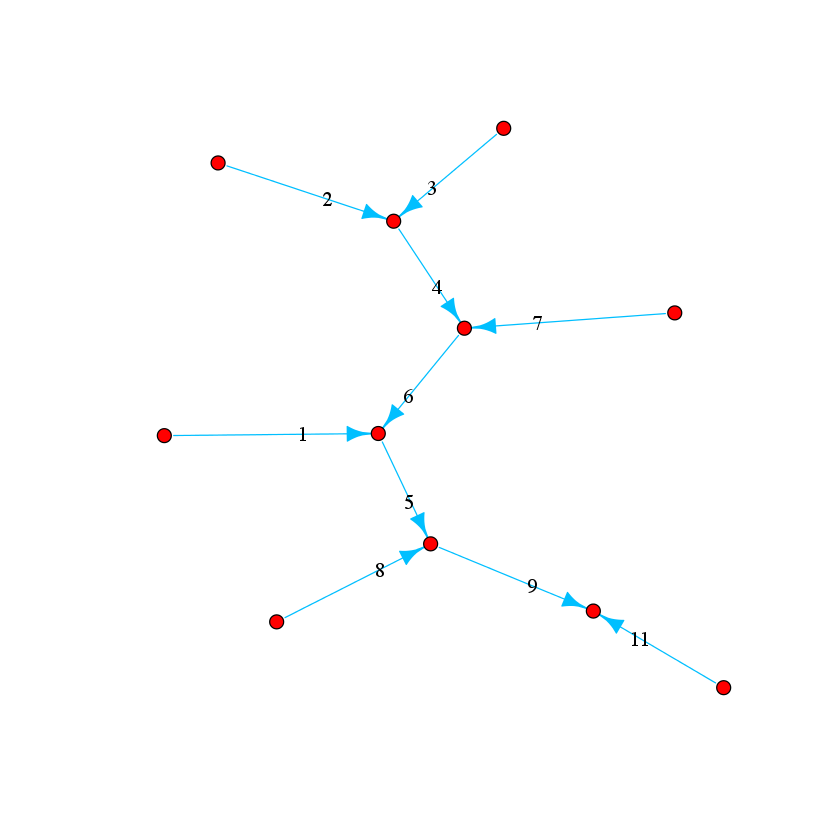

In [461]:
df <- hydroEdges[1:10,]
net <- createNetwork(df)

runoff <- createRandomRunoff(nrow(df), 1)
runoff
#list.edge.attributes(net)
#print(data.frame(catchID=E(net)$catchID, qIn=E(net)$qIn, qOut=E(net)$qOut, sRiv=E(net)$sRiv))


#print(data.frame(name=V(net)$name))
V(net)$size = 5
routeWater(net, runoff, varTable=TRUE, plotNetwork=TRUE)
#runRiverRouting(createNetwork(df), createRandomRunoff(nrow(df), 1))

## Creating test NCDF to Accumulate Runoff with Catchment Raster

In [2]:
library(ncdf)
library(raster)

Loading required package: sp


In [3]:
#testNcdf <- create.ncdf(filename="testNcdf.nc", vars="Rs")
z = matrix(sample(10:30,10000,replace=T), ncol=100)      # matrix of elevations
x = 100* (1:nrow(z))   # meter spacing (S to N)
y = 100* (1:ncol(z))   # meter spacing (E to W)

# define the netcdf coordinate variables -- note these have values!

dim1 = dim.def.ncdf( "EW","kilometers", as.double(x))
dim2 = dim.def.ncdf( "SN","kilometers", as.double(y))

# define the EMPTY (elevation) netcdf variable

varz = var.def.ncdf("Elevation","meters", list(dim1,dim2), -1, 
          longname="The Classic R New Zealand Volcano")

# associate the netcdf variable with a netcdf file   
# put the variable into the file, and
# close

nc.ex = create.ncdf( "example.nc", varz )
put.var.ncdf(nc.ex, varz, z)


In [1]:
lamarQ <- read.table("/Users/hoy/Desktop/MSUWC/Data/usgsGuage/lamarTower2", header=TRUE, stringsAsFactors = FALSE)

In [2]:
lamarQ <- lamarQ[-c(1),]

In [30]:
length(lamarQ$X01_00060_00003)
lamarQ$X01_00060_00003[lamarQ$X01_00060_00003 == "Ice"] <- 0
lamarQ$X01_00060_00003 <- as.numeric(lamarQ$X01_00060_00003)/35.31466666666666667

[1] 27043

In [31]:
head(lamarQ$datetime)

[1] "1923-05-01" "1923-05-02" "1923-05-03" "1923-05-04" "1923-05-05"
[6] "1923-05-06"

In [468]:
plot(tail(lamarQ$X01_00060_00003[], n=1000), type="l")

ERROR: Error in plot(tail(lamarQ$X01_00060_00003[], n = 1000), type = "l"): error in evaluating the argument 'x' in selecting a method for function 'plot': Error in tail(lamarQ$X01_00060_00003[], n = 1000) : 
  error in evaluating the argument 'x' in selecting a method for function 'tail': Error: object 'lamarQ' not found



# Reading in runoff data and aggregating to catchments

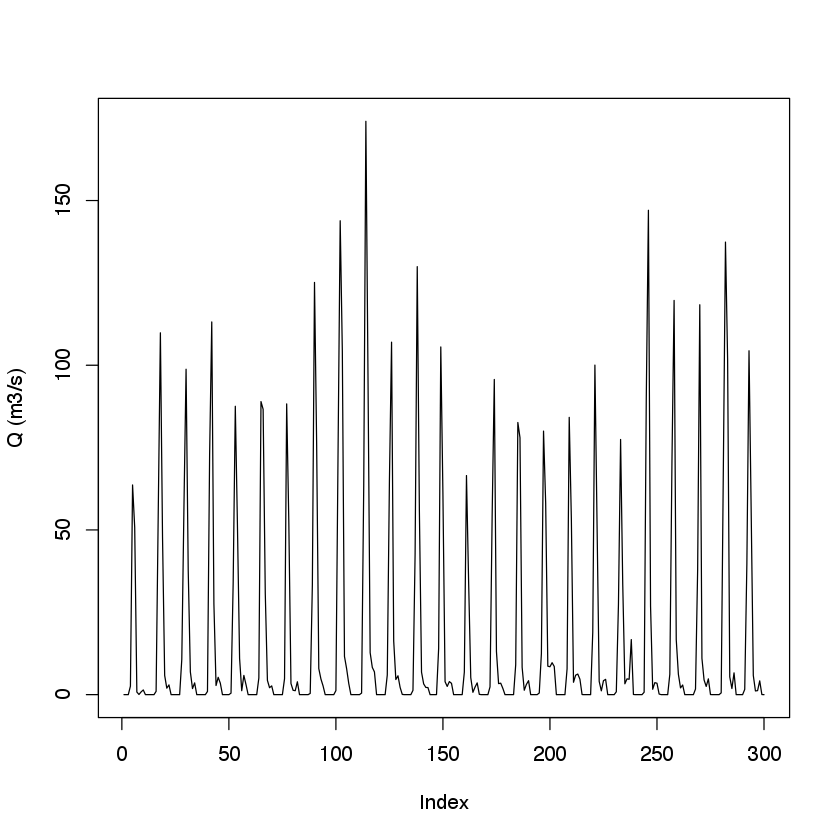

In [83]:
ff <- open.ncdf("/Users/hoy/Desktop/MSUWC/Data/UL_stand_monthly_p100_ID80408.nc")
mro.mm.m2.month <- get.var.ncdf(ff, "mro")
mro.m.m2.month <- mro.mm.m2.month/(1000)         #Convert to meters per month per m2
mro.m3.month <- mro.m.m2.month*1000000                      #Convert to meters per month per gridcell (1km2 grid cell area)
mro.m3.second <- mro.m3.month/(30*24*60*60)     #Convert to meters cubed per second per gridcell

mro.m3.second.basin <- 0

for(m in 1:396){
    mro.m3.second.basin[m] <- sum(mro.m3.second [,,m], na.rm=T)
}
plot(tail(mro.m3.second.basin, n=300), type="l", ylab="Q (m3/s)")
#plot(tail(lamarQ$X01_00060_00003[], n=10000), type="l")

In [21]:
tail(mro.m3.second.basin, n=5)

[1] 1.1356901 1.2255745 4.1903607 0.0379657 0.0000000

In [341]:

routeWaterParallel2 <- function(edges, Rs){#, varTable=FALSE, plotNetwork=FALSE, writeData=FALSE){
    
    #cl <- makeCluster(8)
    #registerDoParallel(cl)

    #Order edges by Shreve order so calculation is in right order
    edges <- edges[order(edges$RiverOrder),]
    
    results <- list(
        qIn = matrix(0, nrow=nrow(Rs), ncol=ncol(Rs), 
                dimnames=list(c(1:nrow(Rs)), edges$HydroID_1)),
        qOut = matrix(0, nrow=nrow(Rs), ncol=ncol(Rs), 
                dimnames=list(c(1:nrow(Rs)), edges$HydroID_1))
    )
    
    
    #Order edges by Shreve order so calculation is in right order 
    foreach(order = icount(max(edges$RiverOrder))) %do% {
    
    #print(paste("Processing edges or order", order))
    
    edgesO <- edges[edges$RiverOrder == order,]
    
    foreach(month = icount(nrow(Rs))) %do% {
        
        
        #print(paste("Processing Month", month, "of order", order))
        
        foreach(i = icount(nrow(edgesO))) %dopar% {
            ###Should set initial values from each edge to speed up
            #sRiv <- E(network)[edge]$sRiv
            
            
            #print(paste("Processing Month", month, "of order", order, "for edge", i))

            
            hydroID <- edgesO[i,]$HydroID_1
            
            if(edgesO[i,]$RiverOrder == 1){
                qIn <- 0
            } else {

                qIn <- sum(results$qOut[month, 
                    c(as.character(
                        edges[edges$NextDownID == edgesO[i,]$HydroID_1,]$HydroID_1))])
                results$qIn[month, as.character(hydroID)] <- qIn #sum(results$qIn[month,c(as.character(parentEdges$HydroID_1))])
            }
            
            results$qOut[month, as.character(hydroID)] <- qIn + Rs[month,as.character(hydroID)]

        }
    }
   }
    return(results)
    
}